In [1]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/covid/france/evolution_par_jour_18_06.csv", sep=",")
df.tail()

,Unnamed: 0,date,granularite,maille_code,maille_nom,cas_confirmes,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,deces,...,hospitalises,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_url,source_archive,source_type,susceptible
136,136,2020-06-13,pays,FRA,France,156813.0,NaN,37599.0,NaN,19014.0,...,10909.0,68.0,14.0,72808.0,NaN,Ministère des Solidarités et de la Santé,NaN,NaN,ministere-sante,66751365.0
137,137,2020-06-14,pays,FRA,France,157220.0,NaN,37599.0,NaN,19023.0,...,10881.0,33.0,6.0,72859.0,NaN,Ministère des Solidarités et de la Santé,NaN,NaN,ministere-sante,66750898.0
138,138,2020-06-15,pays,FRA,France,157372.0,NaN,37599.0,NaN,19052.0,...,10752.0,114.0,12.0,73044.0,NaN,Ministère des Solidarités et de la Santé,NaN,NaN,ministere-sante,66750532.0
139,139,2020-06-16,pays,FRA,France,157716.0,NaN,37901.0,NaN,19090.0,...,10535.0,143.0,14.0,73335.0,NaN,Ministère des Solidarités et de la Santé,NaN,NaN,ministere-sante,66749859.0
140,140,2020-06-17,pays,FRA,France,158174.0,NaN,37901.0,NaN,19118.0,...,10267.0,116.0,14.0,73667.0,NaN,Ministère des Solidarités et de la Santé,NaN,NaN,ministere-sante,66749041.0


In [3]:
df = df[df["date"] < "2020-04-01"]

In [4]:
f = lambda x, param : param*x**2 # la fonction
param_x = 0 # le paramètre à trouver
xrange = list(range(10)) # le nombre de valeurs tests
mesdonnees = [f(i, 2) for i in xrange] # les valeurs tests

In [5]:
params, covariance = scipy.optimize.curve_fit(f, xrange, mesdonnees) # fit
print(f"paramètres = {params}, covariances = {covariance}")

paramètres = [2.], covariances = [[0.]]


In [6]:
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

### Test curve fit sur les données covid (SEIR)

In [7]:
# Total population, N.
N = 67000000
# Initial number of infected and recovered individuals, I0 and R0.
E0, I0, R0 = 1, 3, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - E0
# A grid of time points (in days)
t = np.linspace(0, 80)

# Initial conditions vector
y0 = S0, E0, I0, R0

In [8]:
f = lambda t, beta, gamma, delta : (odeint(deriv, y0, t, args=(N, beta, gamma, delta)).T)[2] # [2] = only Infected
params, covariance = scipy.optimize.curve_fit(f, range(df.shape[0]), df["cas_confirmes"]) # fit
print(f"paramètres = {params}, covariances = {covariance}")

d:\dev\projects\projet_sdd\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


paramètres = [1.08933554 0.91435778 9.06309574], covariances = [[0.00030247 0.00034021 0.0033618 ]
 [0.00034021 0.00040015 0.00192685]
 [0.0033618  0.00192685 0.23537667]]


In [9]:
beta = params[0]
gamma = params[1]
delta = params[2]

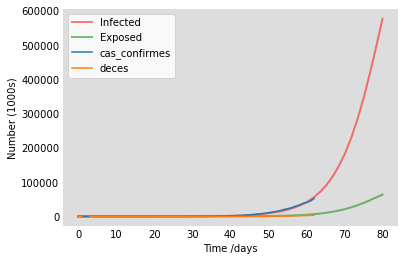

In [10]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma,delta))
S, E, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, E, 'g', alpha=0.5, lw=2, label='Exposed')
#ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
df[["cas_confirmes", "deces"]].plot(ax=ax)

#ax.set_xlim(0, 300)

plt.show()